# Context
Helping Deep Learning and AI Enthusiasts to contribute to improving COVID-19 detection using just Chest X-rays.

# Content
It is a simple directory structure branched into test and train and further branched into the respective 3 classes which contains the images.

# Acknowledgements
Thanks to The University of Montreal for releasing the images.

# Inspiration
Help the medical and researcher community by sharing my work and encourage them to contribute extensively.

# Strategy
Image analysis is a "difficult" problem, where traditional machine learning is likely to struggle. 
Deep learning, has the ability to capture relationships in images by doing both feature extraction and feature generation.
Using tensorflow and a neural network is probably the way to go.

# Data
There are folders split into train and test data. This removes one step of train test splitting.
All the X-ray scans are in grayscale. 
There are three types of cases in the X-rays:
1. Covid with 111 examples
2. Normal  70
3. Viral Pneumonia with 70

These are each a different class that our learning model can output, indicating a multi-class classification with three labels rather than binary classification (covid/not covid).

# Neural Network imports

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

# Data Flow preprocessing
Augmentation, which simply, can be done by shifting or rotating images is applied on the training data.<br>
Since the process for training and validation is different, two generators are made. <br>
A generator loads a certain number of images into memory to later be yielded to a neural network. It prevents us from running out of memory which can easily happen with images.<br>
Also all data is scaled down as neural networks do not work well with large numbers. 

In [2]:
BATCH_SIZE = 16

training_data_generator = ImageDataGenerator(rescale=1./255,
        zoom_range=0.2,
        rotation_range=15,
        width_shift_range=0.05,
        height_shift_range=0.05)

training_iterator = training_data_generator.flow_from_directory('../input/covid19-image-dataset/Covid19-dataset/train',class_mode='categorical',color_mode='grayscale',batch_size=BATCH_SIZE)
validation_data_generator = ImageDataGenerator(rescale=1./255)
validation_iterator = validation_data_generator.flow_from_directory('../input/covid19-image-dataset/Covid19-dataset/test',class_mode='categorical',color_mode='grayscale',batch_size=BATCH_SIZE)

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


# Model Construction
A quite small network consisting of convolutions. The proximity of information in pixels and size of images makes dense layers almost impossible to use. <br>
A convolution will find similar object at different locations in an image. Say for instance properties of covid is likely to be seen at some particular location in an image. Not distributed across all of the image. <br>
Pooling Layers pool local information to reduce the dimensionality of intermediate convolutional outputs. That is we sort of summarize the information in each area of the image.<br>
Flatten reduces the dimensions to 1 so that a Dense layer can be used the prediction of any of the labels. Softmax is used wich gives the probability of each label.

In [3]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(256, 256, 1)))
model.add(tf.keras.layers.Conv2D(2, 5, strides=3, activation="relu")) 
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(5, 5), strides=(5,5)))
model.add(tf.keras.layers.Conv2D(4, 3, strides=1, activation="relu")) 
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2,2), strides=(2,2)))
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(3,activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 84, 84, 2)         52        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 2)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 4)         76        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 4)           0         
_________________________________________________________________
flatten (Flatten)            (None, 196)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 591       
Total params: 719
Trainable params: 719
Non-trainable params: 0
__________________________________________________________

# Accuracy
Accuracy calculates the percentage of predicted values (yPred) that match with actual values (yTrue). So how good the model is overall.
We can also 
# Categorical Accuracy
Categorical Accuracy calculates the percentage of predicted values (yPred) that match with actual values (yTrue) for one-hot labels. So it also takes into acount the different classes.

In [4]:
print("\nCompiling model...")

#Compile the model with an Adam optimizer, Categorical Cross Entropy Loss, and Accuracy and AUC metrics:

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.CategoricalCrossentropy()

model.compile(
    optimizer=opt,
    loss=loss,
    metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC()]
)


Compiling model...


# Fitting the Model
Pretty straight forward. Here I use a large number of epochs + early stopping if the model fails to improve over 3 runs. 
Use model.fit(...) to train and validate our model for 50 epochs:

In [7]:
print("\nTraining model...")
EPOCHS = 5

steps_per_epoch = training_iterator.samples/BATCH_SIZE
validation_steps = validation_iterator.samples/BATCH_SIZE
es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', verbose=1, patience = 3)

history = model.fit(
       training_iterator,
        steps_per_epoch=steps_per_epoch,
        epochs=EPOCHS,
        validation_data=validation_iterator,
        validation_steps=validation_steps,
        callbacks = [es],
        verbose=1) 


Training model...
Epoch 1/5
15/15 [==============================] - 14s 917ms/step - loss: 0.9310 - categorical_accuracy: 0.5697 - auc: 0.7901 - val_loss: 0.8006 - val_categorical_accuracy: 0.7121 - val_auc: 0.9179
Epoch 2/5
15/15 [==============================] - 14s 910ms/step - loss: 0.8193 - categorical_accuracy: 0.7291 - auc: 0.8738 - val_loss: 0.6602 - val_categorical_accuracy: 0.8939 - val_auc: 0.9498
Epoch 3/5
15/15 [==============================] - 14s 882ms/step - loss: 0.6763 - categorical_accuracy: 0.7809 - auc: 0.9143 - val_loss: 0.5230 - val_categorical_accuracy: 0.8636 - val_auc: 0.9620
Epoch 4/5
15/15 [==============================] - 14s 890ms/step - loss: 0.6068 - categorical_accuracy: 0.7849 - auc: 0.9114 - val_loss: 0.4498 - val_categorical_accuracy: 0.8939 - val_auc: 0.9639
Epoch 5/5
15/15 [==============================] - 14s 890ms/step - loss: 0.4938 - categorical_accuracy: 0.8127 - auc: 0.9441 - val_loss: 0.4229 - val_categorical_accuracy: 0.8333 - val_auc

In [8]:
print(history.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'auc', 'val_loss', 'val_categorical_accuracy', 'val_auc'])


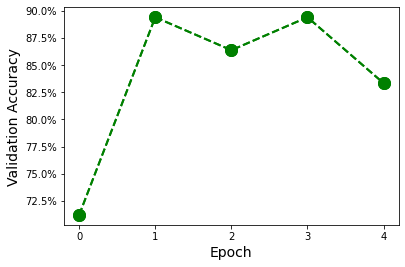

In [28]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(1,1) 

y = np.array(history.history['val_categorical_accuracy']) * 100
x = [i for i in range(EPOCHS)]
plt.plot(x, y, 'go--', linewidth=2, markersize=12)
plt.plot(x, y, color='green', marker='o', linestyle='dashed',  linewidth=2, markersize=12)
plt.ylabel('Validation Accuracy', fontsize=14)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xlabel('Epoch', fontsize=14)
plt.xticks(ticks=x, labels=None) # , **kwargs
plt.show()

In [ ]:
weights = model.get_weights()
#weights